# Overview

The goal of this notebook is to demonstrate how ``GraPE`` for a more advanced workflow and in the context of hyperparameter optimization. Specifically, we will have a look at global features and demonstrating how we used the **BOHB** (Bayesian Optimization with HyperBand) by [1] as implemented in ``Ray-Tune``.

# Using Global Features

A global feature is a type of data that, in the context of molecules and graphs, describes extra, graph level information. Specifically, global features *are not* the target of whatever problem a GNN tries to solve. For instance, if we use the ``QM9`` dataset ([link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html)), we could use the *heat capacity* as our primary target and the *Dipole moment* as our global feature. These global features are then concatenated to the (last) latent representation of the GNN (after read-out). This simple introduction of the global features to the system has been shown to yield higher performance [2] without any new cost. 

In the following, we will train a simple MPNN on the QM9 dataset using the heat capacity as our target and and the Dipole moment as a global feature.

In [1]:
from grape.datasets import QM9

# The ids are based on the way it is stored in PyG
data = QM9(target_id=5, global_feature_id=0)

In [2]:
print('Some example features:\n')
print('SMILES: ', data.smiles[:10], '\n')
print('Heat capacity: ', data.target[:10], '\n')
print('Dipole moment: ',data.global_features[:10], '\n')

Some example features:

SMILES:  ['C#C' 'C#N' 'C=O' 'CC' 'CO' 'C#CC' 'CC#N' 'CC=O' 'NC=O' 'CCC'] 

Heat capacity:  [ 59.5248  48.7476  59.9891 109.5031  83.794  177.1963 160.7223 166.9728
 145.3078 227.1361] 

Dipole moment:  tensor([0.0000, 1.6256, 1.8511, 0.0000, 2.8937, 2.1089, 0.0000, 1.5258, 0.7156,
        3.8266]) 



To reduce the computation time for this example, we will only consider a subset of 3000 SMILES from QM9. However, one can just skip the following step if the whole dataset is to be used:

In [3]:
from grape.utils import DataSet


data = DataSet(smiles=data.smiles[:3000], target=data.target[:3000],
                           global_features=data.global_features[:3000])

We now prepare the data as usual:

In [4]:
train, val, test = data.split_and_scale(scale=True, split_type='random', seed=1234)

Initializing the model:

In [5]:
from grape.models import MPNN

model = MPNN(node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features, num_global_feats=1)

**Note that we must now specify how many global features we are adding,** in addition to how many node and edge features we have. But the rest stays the same.

Let us now specify all the required training elements:

In [6]:
import torch
from grape.utils import EarlyStopping
from torch.optim import lr_scheduler

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


# Early stopper
early_stopper = EarlyStopping(patience=30, model_name='best_model')

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, min_lr=0.0000000000001, patience=15)

We now train and plot the training/validation loss:

epoch=238, training loss= 0.018, validation loss= 0.068:  79%|███████▉  | 238/300 [02:16<00:35,  1.74it/s]

Early stopping reached with best validation loss 0.0609
Model saved at: best_model.pt


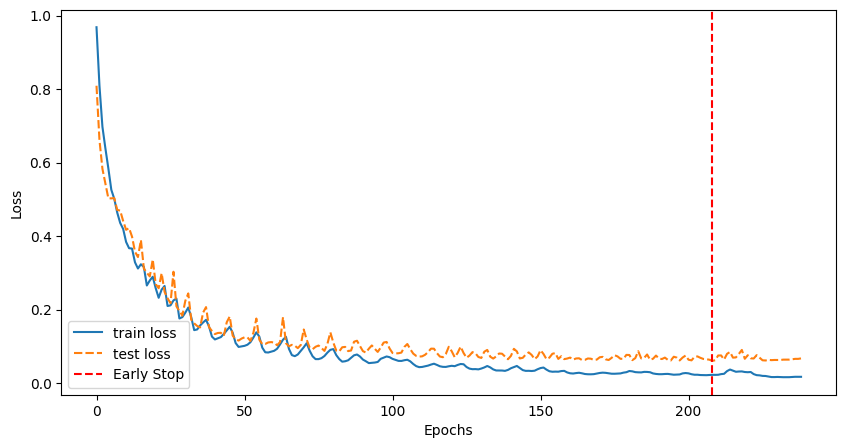

In [7]:
from grape.utils import train_model

train_loss, val_loss = train_model(model = model,
                                  loss_func = 'mse',
                                  optimizer = optimizer,
                                  train_data_loader= train,
                                  val_data_loader = val,
                                  batch_size=300,
                                  epochs=300,
                                  early_stopper=early_stopper,
                                   scheduler=scheduler)

model.load_state_dict(torch.load('best_model.pt'))

from grape.plots import loss_plot
loss_plot([train_loss, val_loss], ['train loss', 'test loss'], early_stopper.stop_epoch)

As one might be able to tell from the above code, the only two things that changed was (1) we need to initialize/use data that has a valid global feature and (2) we need to specify how many global features we are adding to the model.

If global features are available, it is worth adding them! 

# BOHB and Hyperparameter Optimization

In this second part of the advanced demonstration, we will have a look at hyperparameter optimization, how GraPE fits in and Ray-Tune. Note that for this, we need to install the packages:

``ray``, ``ConfigSpace==0.4.18`` and ``hpbandster==0.7.4``.

Let us briefly review what the core of the BOHB algorithm is. Essentially, it consists of two parts: Bayesian Optimization [3] (BO-) and HyperBand [4] (-HB), each acting as the search algorithm and a trial scheduler respectively. Bayesian optimization leverages Gaussian processes to sample the search space in a 'smart' way that optimizes the evaluation metric, and while it is very powerful, it can take a long time. To offset this, BOHB adds HyperBand, which is a bandit-based trial scheduler, capable of terminating and restarting trials to maximize trial run-time efficiency. Together, these two algorithm profit from each others strengths.


For more information on the algorithm itself please see their GitHub repo ([github](https://github.com/automl/HpBandSter.git)) or their blog post reviewing their paper ([blog-post](https://www.automl.org/blog_bohb/)).

## Ray Tune

Ray (https://github.com/ray-project/ray) and specifically Ray Tune is a package offers streamlined hyperparameter optimization. For hyperparameter optimization using it, we need three things:
* a parameter search space
* an objective function which contains training and validation
* a ray tuner

For more information on how to use BOHB with ray-tune please check out ([using BOHB](https://docs.ray.io/en/latest/tune/examples/bohb_example.html)) and ([using checkpoints](https://docs.ray.io/en/latest/train/user-guides/checkpoints.html#train-checkpointing)).

The model we will be using is AFP and the dataset is FreeSolv. As for hyperparameters, let us optimize the learning rate, the hidden (node) representation size and the number of hidden output (MLP) layers.

Let us start with defining the search space:

In [11]:
import ConfigSpace as CS
config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformIntegerHyperparameter("mlp_out", lower=1, upper=5))
config_space.add_hyperparameter(CS.UniformIntegerHyperparameter("gnn_hidden_dim", lower=32, upper=256))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter('initial_lr', lower=1e-5, upper=1e-1));

Now we need to define an objective function. Specifically, this function needs to (1) take a configuration dictionary ``config`` holding the trial hyperparameters, (2) load a model based on that config-dictionary and (3) load the correct data. All of this needs to happen **inside** the function, as Tune will need to load multiple different instances of data and models.

In [26]:
import os
import tempfile
from grape.models import AFP
from grape.datasets import FreeSolv
from grape.utils import return_hidden_layers, train_epoch, val_epoch, set_seed
from torch_geometric.loader import DataLoader
from ray.train import Checkpoint

# Seed everything
set_seed(42)

def trainable(config: dict, device:torch.device):
        """ The trainable for Ray-Tune.

        Parameters
        -----------
            config: dict
                A ConfigSpace dictionary adhering to the required parameters in the trainable. Defines the search space of the HO.
            device: torch.device
        """
        
        ################ load the data ##############
        data = FreeSolv()
        train_set, val_set, _ = data.split_and_scale(scale=True, split_type='random')
        train_data = DataLoader(train_set, batch_size = 300)
        val_data = DataLoader(val_set, batch_size = 300)
        
        ################ load the model ##############
        
        # Get mlp hidden layers
        mlp = return_hidden_layers(config['mlp_out'])
        
        # Define the model
        model = AFP(node_in_dim=data.num_node_features,edge_in_dim=data.num_edge_features, hidden_dim=config['gnn_hidden_dim'], mlp_out_hidden=mlp)
        model.to(device=device)

        
        # We define training stuff
        optimizer = torch.optim.Adam(model.parameters(), lr=config['initial_lr'], weight_decay=1e-6)
        early_Stopper = EarlyStopping(patience=30, model_name='random', skip_save=True)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.999, min_lr=1e-10, patience=10)
        loss_function = torch.nn.functional.l1_loss

        iterations = 300

        start_epoch = 0
        
        # HyperBand uses checkpoint, so we need to check whether to load one
        checkpoint = train.get_checkpoint()

        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                model_state_dict = torch.load(
                    os.path.join(checkpoint_dir, "model.pt"),
                    # map_location=...,  # Load onto a different device if needed.
                )
                model.module.load_state_dict(model_state_dict)
                optimizer.load_state_dict(
                    torch.load(os.path.join(checkpoint_dir, "optimizer.pt"))
                )
                start_epoch = (
                    torch.load(os.path.join(checkpoint_dir, "extra_state.pt"))["epoch"] + 1
                )
        
        model.train()

        for i in range(start_epoch, iterations):
            # We take a training step
            train_loss = train_epoch(model=model, loss_func=loss_function, optimizer=optimizer,train_loader=train_data, device=device)
            # Then we validate that step
            val_loss = val_epoch(model=model, loss_func=loss_function, val_loader=val_data, device=device)
            scheduler.step(val_loss)
            
            # We check if we reached early stopping, and if so break out of the loop
            early_Stopper(val_loss=val_loss, model=model)
            if early_Stopper.stop:
                train.report({"mae_loss": val_loss})
                break
            
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint = None
                
                # We save a checkpoint if we don't early stop and are on n*15 epoch
                should_checkpoint = i % config.get("checkpoint_freq", 15) == 0
                # In standard DDP training, where the model is the same across all ranks,
                # only the global rank 0 worker needs to save and report the checkpoint
                if train.get_context().get_world_rank() == 0 and should_checkpoint:
                    # === Make sure to save all state needed for resuming training ===
                    torch.save(
                        model.module.state_dict(),  # NOTE: Unwrap the model.
                        os.path.join(temp_checkpoint_dir, "model.pt"),
                    )
                    torch.save(
                        optimizer.state_dict(),
                        os.path.join(temp_checkpoint_dir, "optimizer.pt"),
                    )
                    torch.save(
                        {"epoch": i},
                        os.path.join(temp_checkpoint_dir, "extra_state.pt"),
                    )
                    # ================================================================
                    checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                
                # We report the training criteria
                train.report({"mae_loss": val_loss}, checkpoint=checkpoint)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


The warning above is because we are working in the jupyter environment. The final building block to optimize is the ``Tuner``, essentially the object that controls the training procedure:

In [35]:
from functools import partial
from ray import tune, train
from ray.tune.search.bohb import TuneBOHB
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu = 1
else:
    device = torch.device("cpu")
    gpu = 0
    
# Partially initialize the trainable
my_trainable = partial(trainable, device=device)

# Give the tuner CPU and GPU resources
trainable_with_resources = tune.with_resources(my_trainable, {"cpu":1, "gpu":gpu})

### Define search algorithm to be BOHB
algo = TuneBOHB(config_space,mode='min', metric="mae_loss",)

## Get the trial control algorithm
scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=10, # The iterations allowed per instance
    )

n_samples = 5 # These are the number of trials, ie. we should increase this for better results.

## Initialize the tuner
tuner = tune.Tuner(trainable_with_resources,
              tune_config=tune.TuneConfig(
                                        scheduler=scheduler,
                                        search_alg=algo,
                                        mode='min',
                                        metric="mae_loss",
                                        num_samples=n_samples),
              run_config=train.RunConfig(
                                        name="bo_exp",
                                        stop={"training_iteration": 100}),
)

That's it! The above code is (mostly) dataset and model agnostic, so we can freely change them around. Furthermore, we can either run this locally or remote (HPC) and scale it up as much as we want. But we have to be a bit careful if we want to switch out the algorithm or scheduler, as this will change some small details.

Let us run the optimizer:

In [36]:
result = tuner.fit(); # We suppress the output because it is quite long, but feel free to have a look yourself.

2024-06-02 16:51:44,171	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1
2024-06-02 16:51:47,072	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1
2024-06-02 16:51:50,262	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1
2024-06-02 16:51:54,269	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=3; Now=1
2024-06-02 16:51:55,442	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the curre

In [38]:
print('Best config is: ', result.get_best_result().config)

Best config is:  {'gnn_hidden_dim': 106, 'initial_lr': 0.0922370639167152, 'mlp_out': 1}


And that is our best set of hyperparameters for this (small) set of trials! Like mentioned, we expect the result to get better and better (up to a certain point) as we increase the number of trials.

# References:

[1] Falkner, S., Klein, A., & Hutter, F. (2018). Bohb: Robust and efficient hyperparameter optimization at scale.

[2] Na, G. S., Kim, H. W., & Chang, H. (2020). Costless performance improvement in machine learning for graph-based molecular analysis [PMID: 31928003]. Journal of Chemical Information and Modeling, 60 (3), 1137–1145. https://doi.org/10.1021/acs.jcim.9b00816

[3] Shahriari, B., Swersky, K., Wang, Z., Adams, R. P., & de Freitas, N. (2016). Taking the human out of the loop: A review of bayesian optimization. Proceedings of the IEEE, 104 (1), 148–175. https://doi.org/10.1109/JPROC.2015.2494218

[4] Li, L., Jamieson, K., DeSalvo, G., Rostamizadeh, A., & Talwalkar, A. (2018). Hyperband: A novel bandit-based approach to hyperparameter optimization.

In [44]:
!export PATH=/Library/TeX/texbin:$PATH
!jupyter nbconvert 'Advanced GraPE Demonstration.ipynb' --to pdf --no-prompt

[NbConvertApp] Converting notebook Advanced GraPE Demonstration.ipynb to pdf
[NbConvertApp] Support files will be in Advanced GraPE Demonstration_files/
[NbConvertApp] Making directory ./Advanced GraPE Demonstration_files
[NbConvertApp] Writing 55278 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 113050 bytes to Advanced GraPE Demonstration.pdf
